In [131]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def data_generator(n, df):
    data = np.abs(np.random.standard_t(df, size=n))
    return (data - np.mean(data)) / np.std(data)

def estimator(N, k, O, df):
    # Generate data
    data = data_generator(N, df)

    # Adding outliers
    if O > 0:
        replace_indices = np.random.choice(N, O, replace=False)
        data[replace_indices] = x0

    groups = np.array_split(data, k)
    mu_bar = np.array([np.mean(g) for g in groups])
    sigma_hat = np.array([np.std(g, ddof=1) for g in groups])

    # Calculate mu_MOM
    mu_MOM = np.median([np.mean(g) for g in groups])

    # Calculate mu_hat_N_1
    alpha = (1 / sigma_hat**1) / np.sum(1 / sigma_hat**1)
    mu_hat_N_1 = np.sum(alpha * mu_bar)

    # Calculate mu_hat_N_2
    alpha = (1 / sigma_hat**2) / np.sum(1 / sigma_hat**2)
    mu_hat_N_2 = np.sum(alpha * mu_bar)

    # Calculate mu_Trim
    epsilon = O / N
    trimmed_data = np.sort(data)[
        (np.floor(epsilon * N) + 5).astype(int): -(np.floor(epsilon * N) + 5).astype(int)#epsilon * N=0
    ]
    mu_Trim = np.mean(trimmed_data)

    return mu_MOM, mu_hat_N_1, mu_hat_N_2, mu_Trim


def simulator(N, k_values, O_values, df, simulations, x0):
    results = []
    mu_MOM_print = []
    for O in O_values:
        for k in k_values:
            mu_MOM_errors = []
            mu_hat_N_1_errors = []
            mu_hat_N_2_errors = []
            mu_Trim_errors = []

            for _ in range(simulations):
                mu_MOM, mu_hat_N_1, mu_hat_N_2, mu_Trim = estimator(N, k, O, df)

                # Calculate errors
                true_mean = 0
                mu_MOM_errors.append(mu_MOM - true_mean)
                mu_hat_N_1_errors.append(mu_hat_N_1 - true_mean)
                mu_hat_N_2_errors.append(mu_hat_N_2 - true_mean)
                mu_Trim_errors.append(mu_Trim - true_mean)
                mu_MOM_print.append(mu_MOM)

            results.append({
                "O": O,
                "k": k,
                "mu_MOM_avg_error": np.mean(mu_MOM_errors),
                "mu_MOM_std": np.std(mu_MOM_errors),
                "mu_MOM_max_error": np.max(np.abs(mu_MOM_errors)),
                "mu_hat_N_1_avg_error": np.mean(mu_hat_N_1_errors),
                "mu_hat_N_1_std": np.std(mu_hat_N_1_errors),
                "mu_hat_N_1_max_error": np.max(np.abs(mu_hat_N_1_errors)),
                "mu_hat_N_2_avg_error": np.mean(mu_hat_N_2_errors),
                "mu_hat_N_2_std": np.std(mu_hat_N_2_errors),
                "mu_hat_N_2_max_error": np.max(np.abs(mu_hat_N_2_errors)),
                "mu_Trim_avg_error": np.mean(mu_Trim_errors),
                "mu_Trim_std": np.std(mu_Trim_errors),
                "mu_Trim_max_error": np.max(np.abs(mu_Trim_errors)),
            })

    return results, mu_MOM_print

def truncat(data, column, O_values, truncation_rules):
    for O, max_value in truncation_rules.items():
        mask = (data["O"] == O) & (data[column] > max_value)
        data.loc[mask, column] = max_value
    return data

def plots(results_df, O_values, error_types, estimators, title_prefix):
    markers = {"mu_MOM": "o", "mu_hat_N_1": "*", "mu_hat_N_2": "X", "mu_Trim": "D",}
    colors = {"mu_MOM": "blue", "mu_hat_N_1": "red", "mu_hat_N_2": "yellow", "mu_Trim": "purple",}
    plt.figure(figsize=(12, 8))
    handles = []
    labels = []
    for i, O in enumerate(O_values):
        subset = results_df[results_df["O"] == O]
        ax = plt.subplot(2, 2, i + 1)
        for estimator in estimators:
            marker = markers[estimator]
            color = colors[estimator]
            scatter = ax.scatter(
                subset["k"],
                subset[f"{estimator}_{error_types}"],
                label=f"{estimator}_{error_types}",
                facecolors='none',
                edgecolors=color,
                marker=marker,
                s=60)
            if i == 0:
                handles.append(scatter)
                labels.append(f"{estimator}_{error_types}")
        ax.set_title(f"{title_prefix} (O={O})")
        ax.set_xlabel("k")
        ax.set_ylabel(title_prefix)
        ax.grid()
    plt.legend(handles=handles, labels=labels, loc='center', bbox_to_anchor=(0.5, -0.3), ncol=2)
    plt.tight_layout()
    plt.show()

#plot_mu_MOM2(mu_MOM_print, O_values, k_values, simulations)
def plot_mu_MOM2(mu_MOM_print, O_values, k_values, simulations):
    index = 0

    for O in O_values:
        for k in k_values:
            subset = mu_MOM_print[index : index + simulations]

            if len(subset) == 0:
                break

            x_values = list(range(index, index + len(subset)))

            plt.figure(figsize=(6, 4))
            plt.scatter(x_values, subset, label=f"O={O}, k={k}", color="blue", s=20)
            plt.xlabel("Index")
            plt.ylabel("mu_MOM value")
            plt.title(f"mu_MOM for O={O}, k={k}")
            plt.legend()
            plt.grid()
            plt.show()

            index += simulations

def plot_mu_MOM_hist(mu_MOM_print, O_values, k_values, simulations, bins=20):
    index = 0
    for O in O_values:
        for k in k_values:
            subset = mu_MOM_print[index : index + simulations]
            if len(subset) == 0:
                break
            plt.figure(figsize=(6, 4))
            plt.hist(subset, bins=bins, color="blue", alpha=0.7, edgecolor="black")
            plt.xlabel("mu_MOM values")
            plt.ylabel("Frequency")
            plt.title(f"Histogram for O={O}, k={k}")
            plt.grid(axis="y", linestyle="--", alpha=0.7)
            plt.show()
            index += simulations


error_types = ["avg_error", "std", "max_error"]
estimators = ["mu_MOM", "mu_hat_N_1", "mu_hat_N_2", "mu_Trim"]


In [132]:
N = 2500
O_values = [0, 50, 100, 150]
k_values = [25, 50, 75, 100, 125, 150, 175, 200]
df = 4
simulations = 1000
x0 = 10**3

results, mu_MOM_print = simulator(N, k_values, O_values, df, simulations, x0)


In [133]:
results_df = pd.DataFrame(results)
std_columns = ["mu_MOM_std", "mu_hat_N_1_std", "mu_hat_N_2_std", "mu_Trim_std"]
results_df[std_columns] = results_df[std_columns] * np.sqrt(N)
#large values were truncated to show results on appropriate scale
average_error_rules = {50: 3, 100: 3, 150: 4}
std_rules = {50: 5, 100: 5, 150: 5}
max_error_rules = {50: 5, 100: 5, 150: 5}

for estimator in ["mu_MOM_avg_error", "mu_hat_N_1_avg_error", "mu_hat_N_2_avg_error", "mu_Trim_avg_error"]:
    results_df = truncat(results_df, estimator, O_values, average_error_rules)
for estimator in ["mu_MOM_std", "mu_hat_N_1_std", "mu_hat_N_2_std", "mu_Trim_std"]:
    results_df = truncat(results_df, estimator, O_values, std_rules)
for estimator in ["mu_MOM_max_error", "mu_hat_N_1_max_error", "mu_hat_N_2_max_error", "mu_Trim_max_error"]:
    results_df = truncat(results_df, estimator, O_values, max_error_rules)

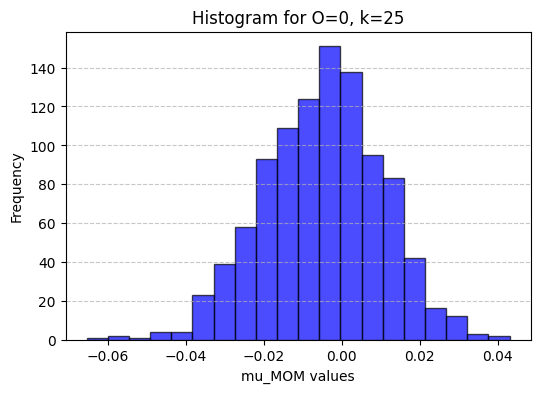

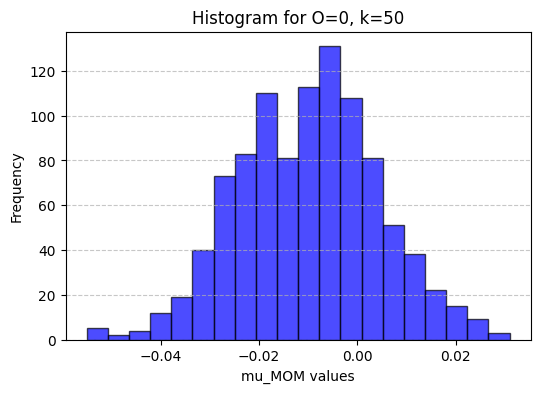

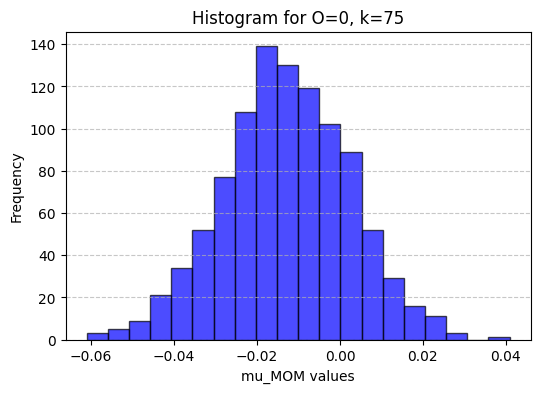

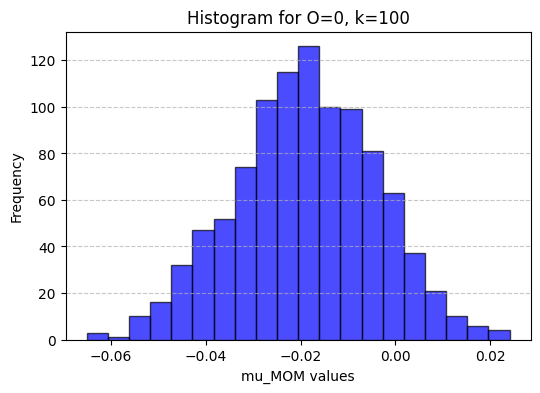

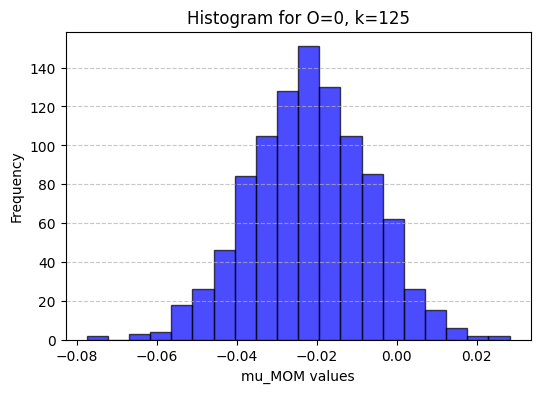

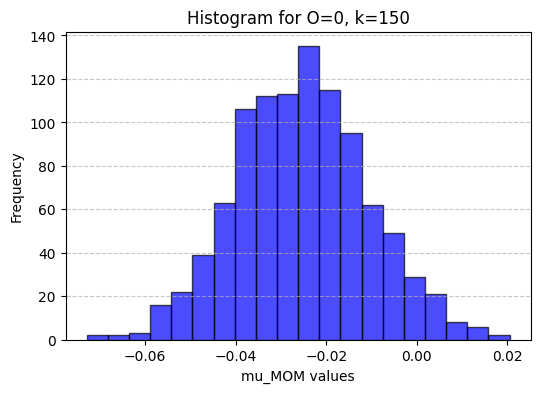

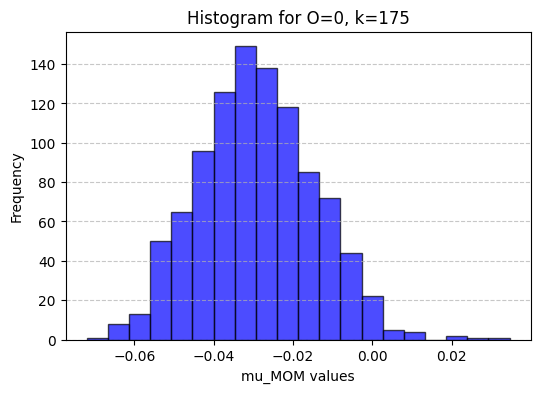

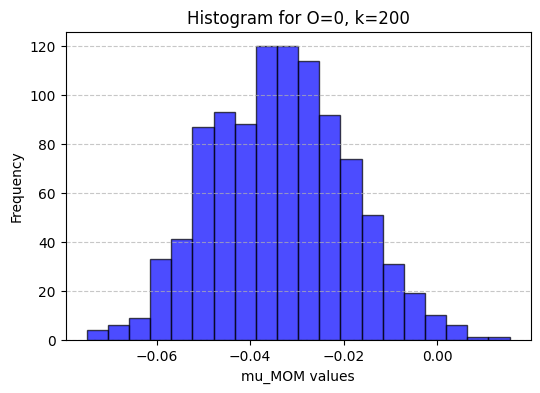

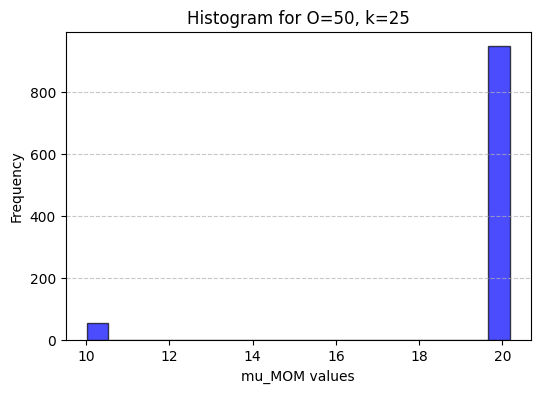

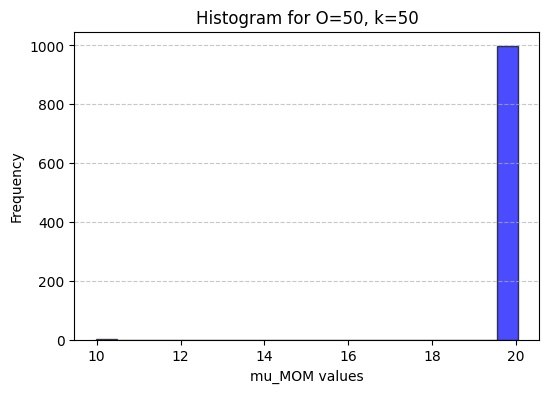

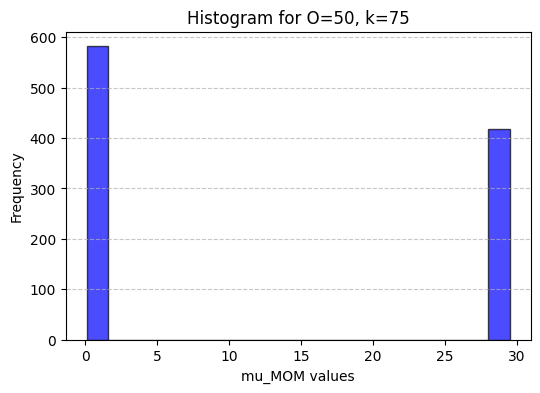

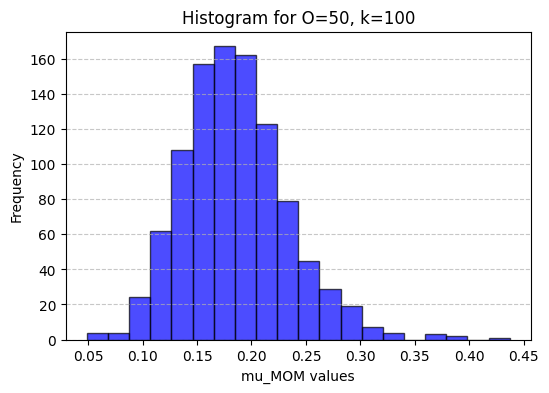

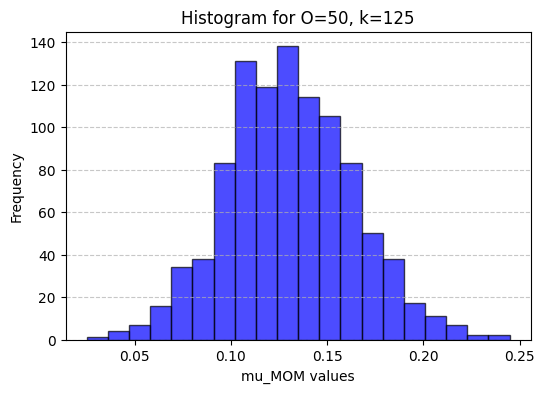

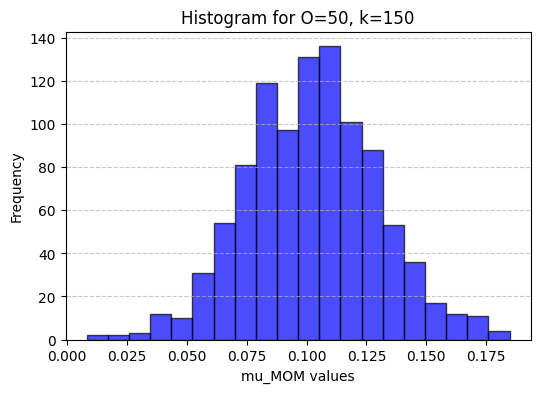

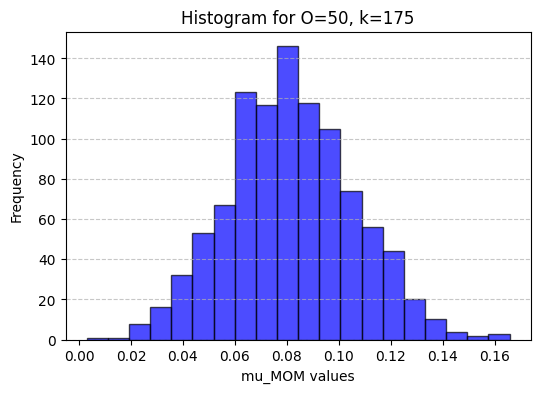

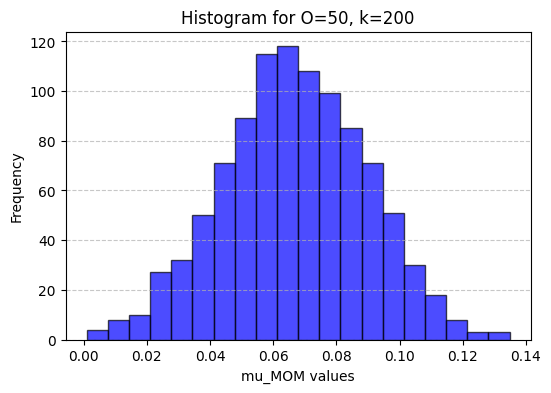

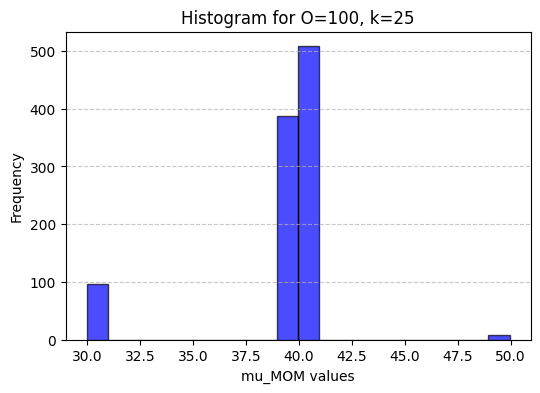

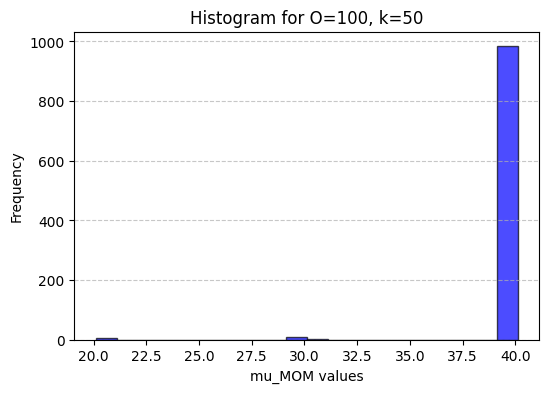

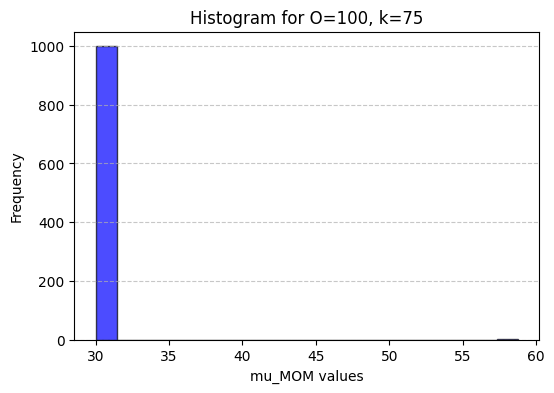

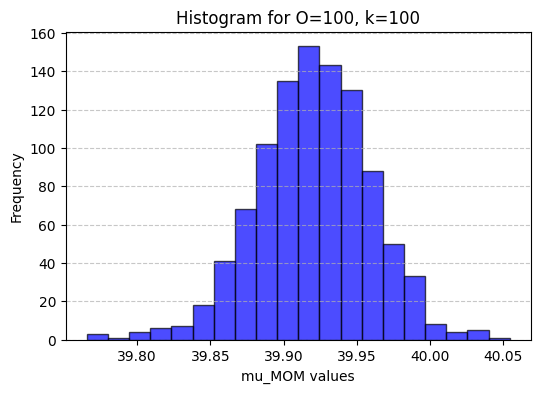

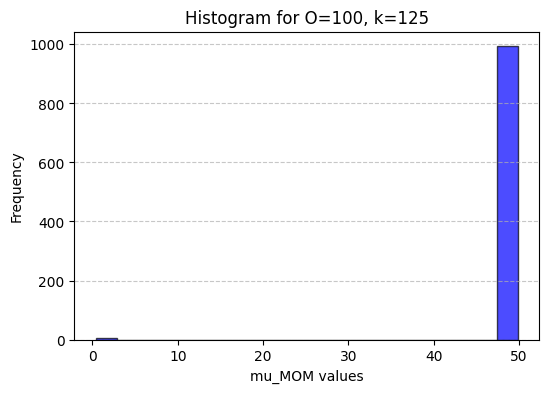

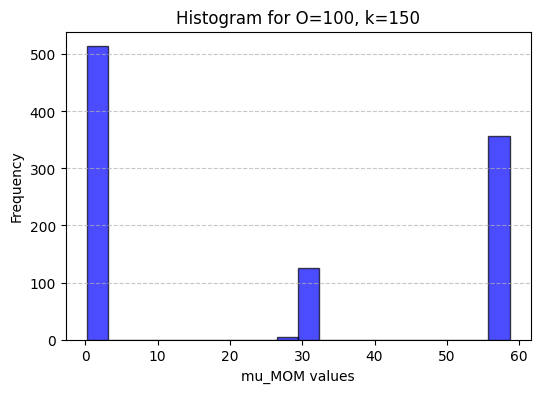

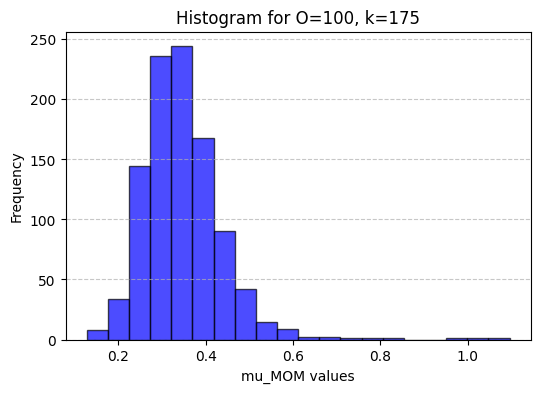

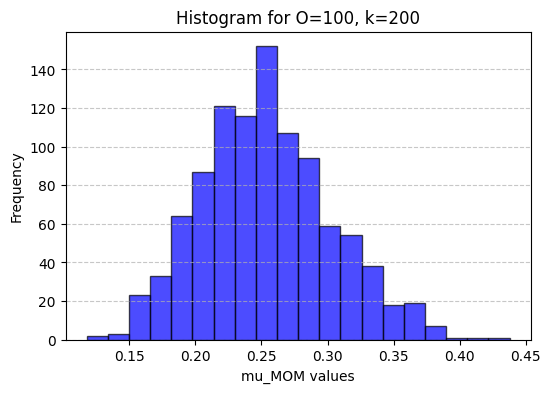

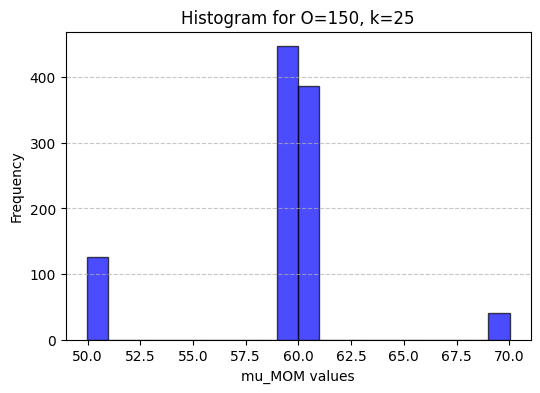

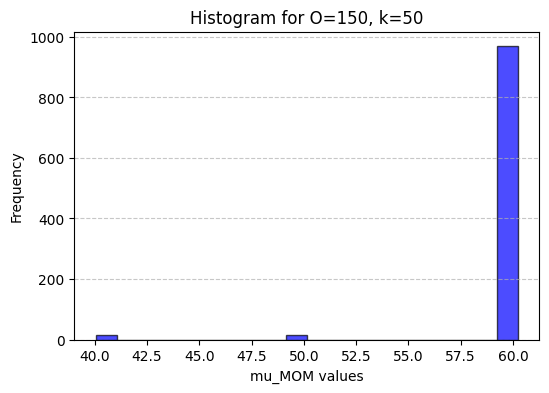

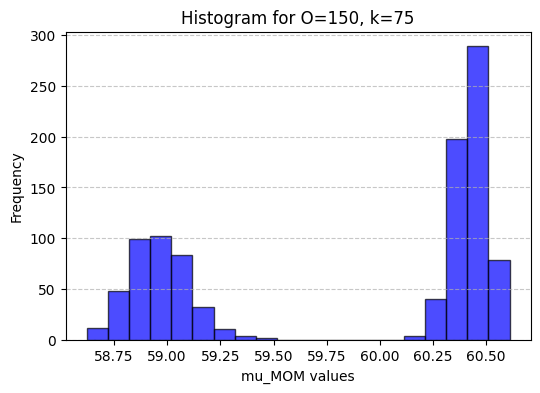

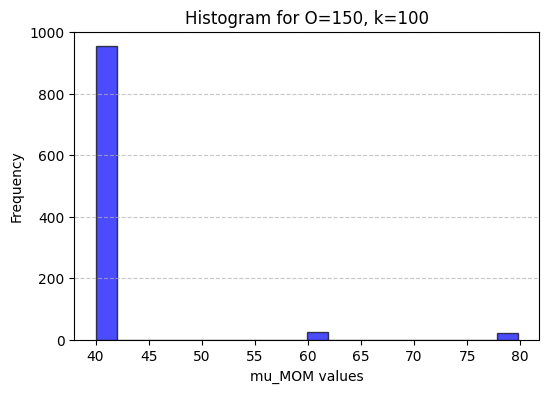

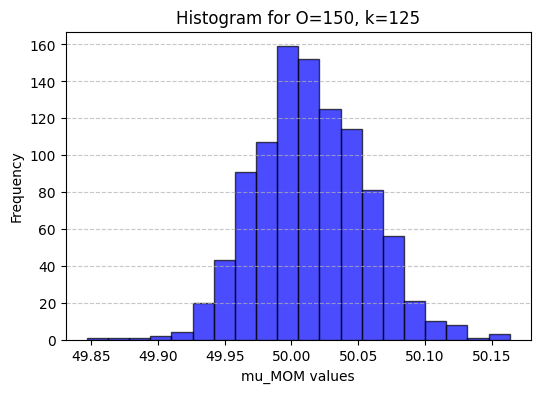

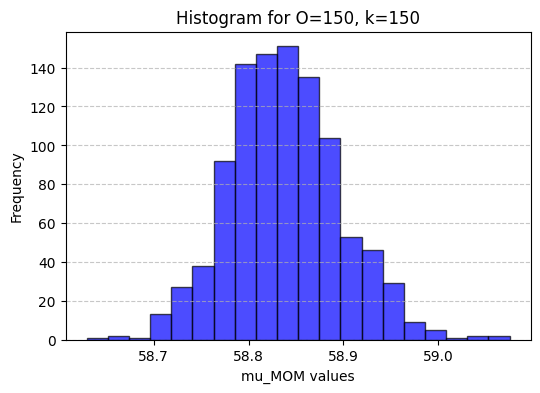

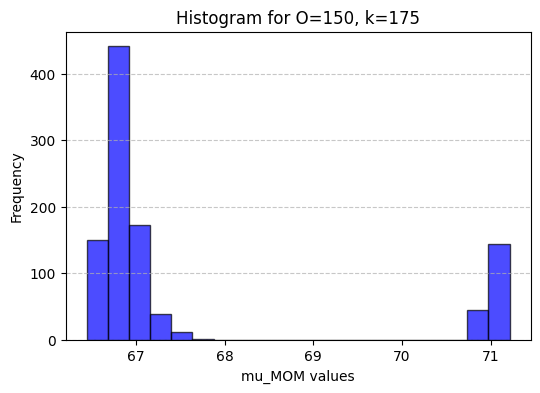

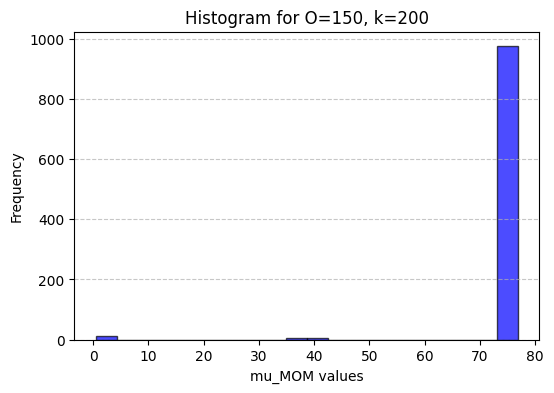

In [138]:
bins = 20
plot_mu_MOM_hist(mu_MOM_print, O_values, k_values, simulations, bins)

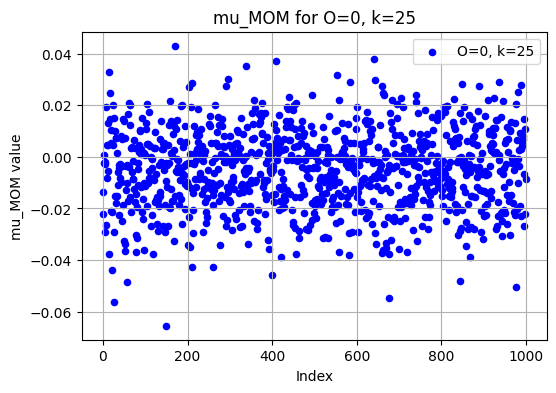

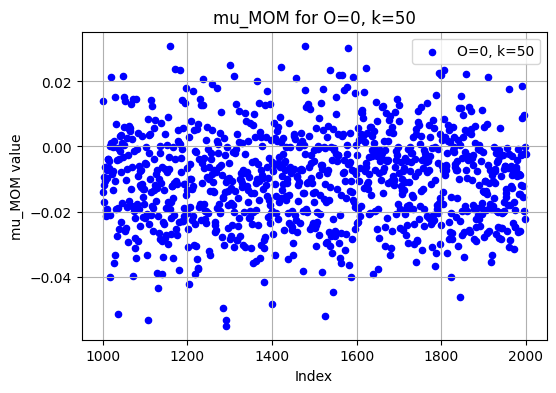

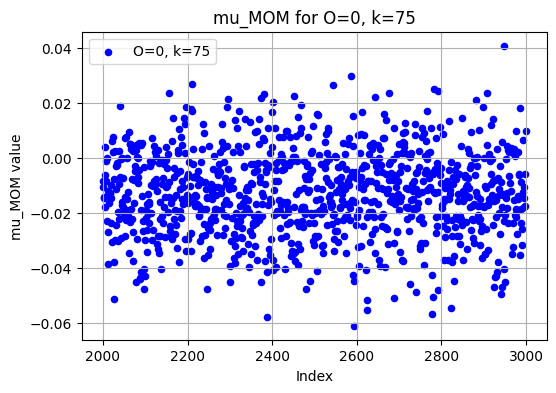

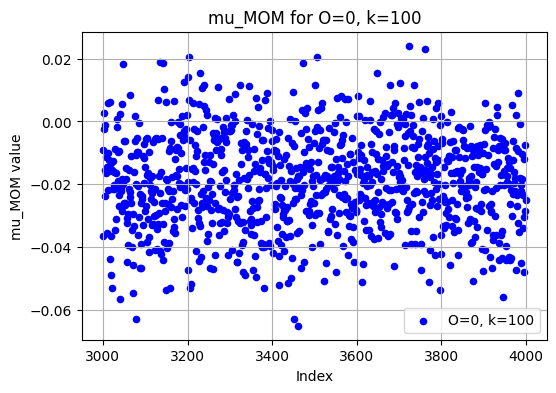

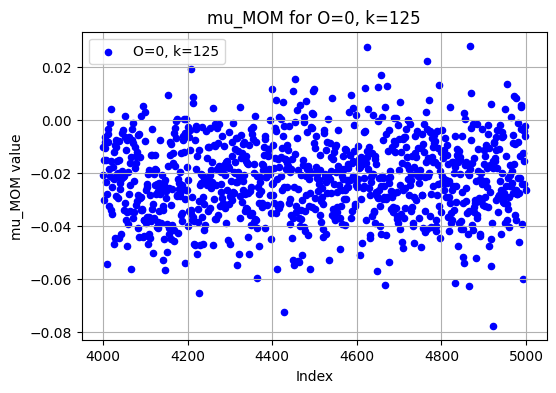

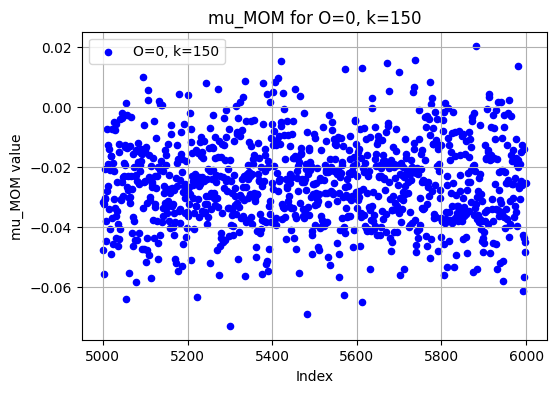

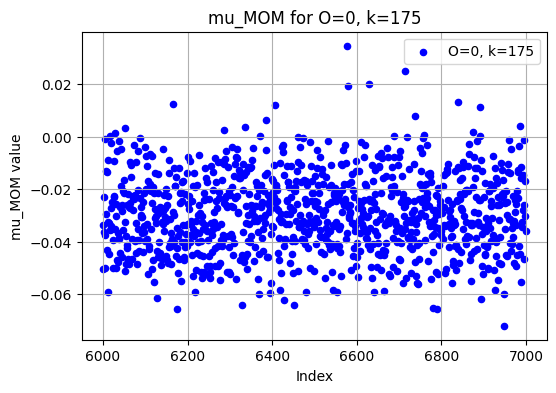

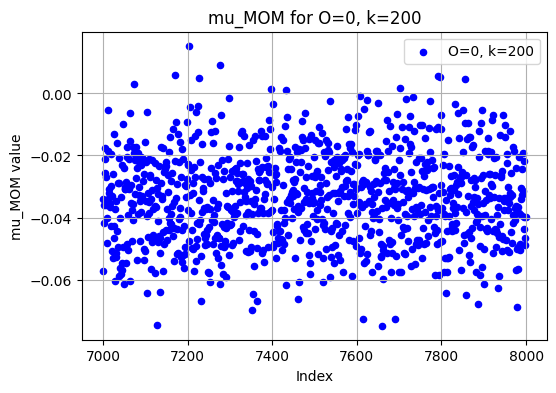

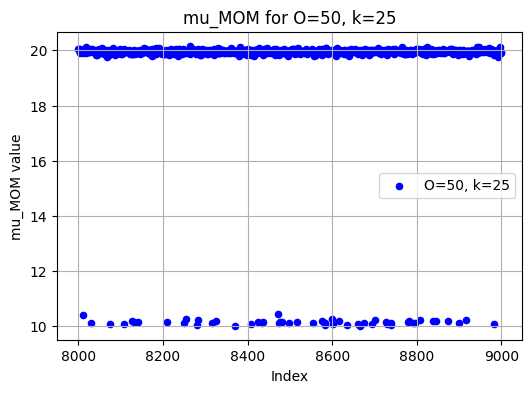

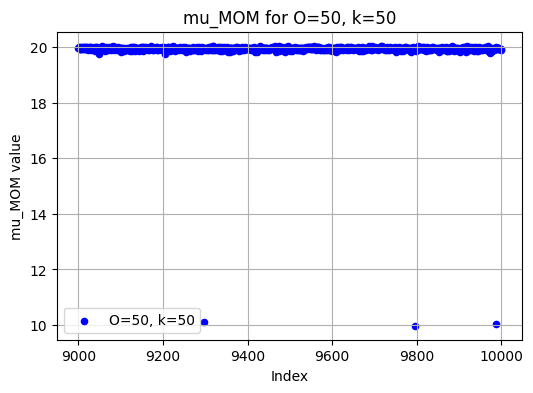

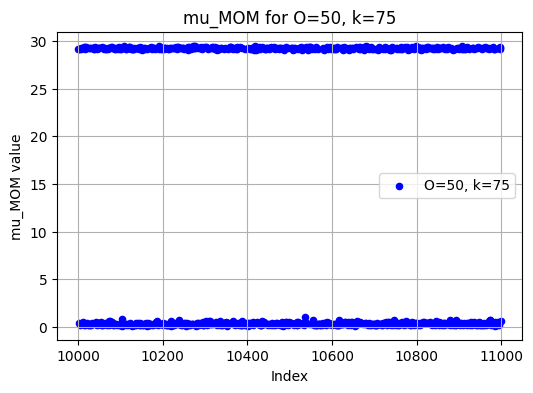

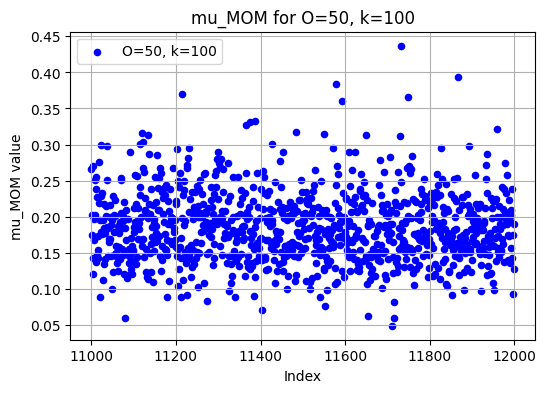

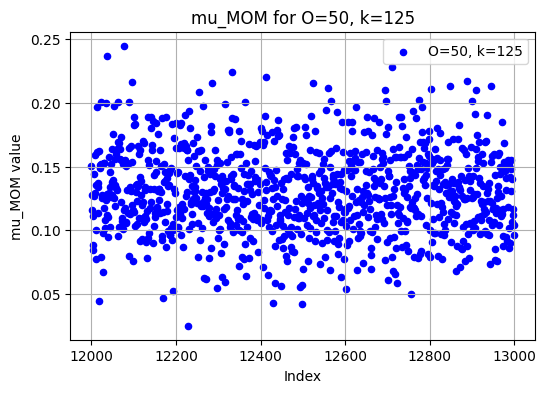

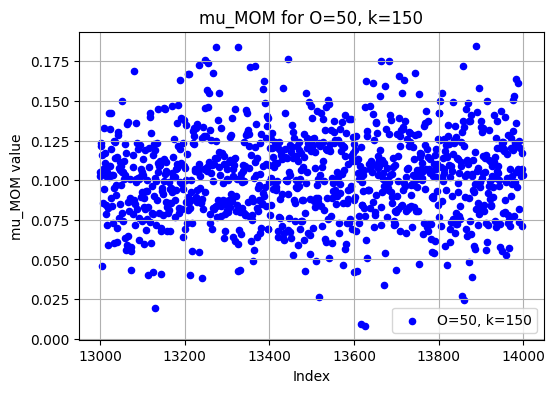

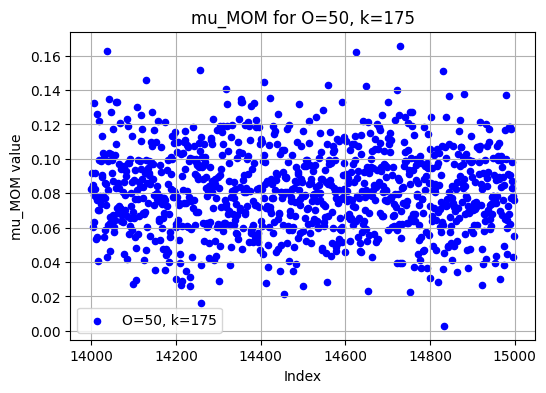

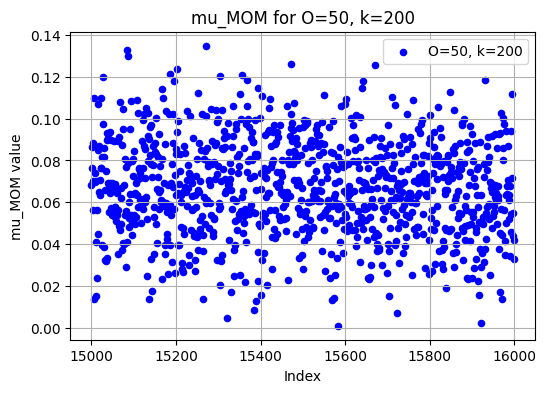

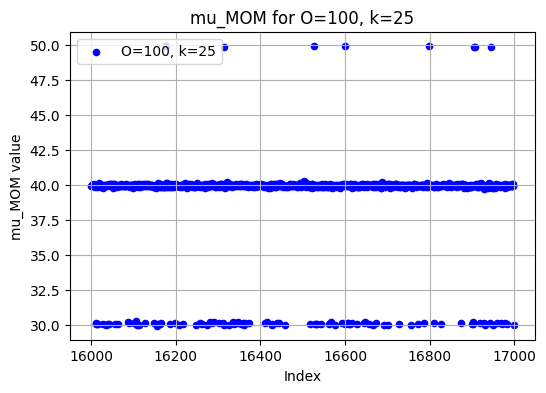

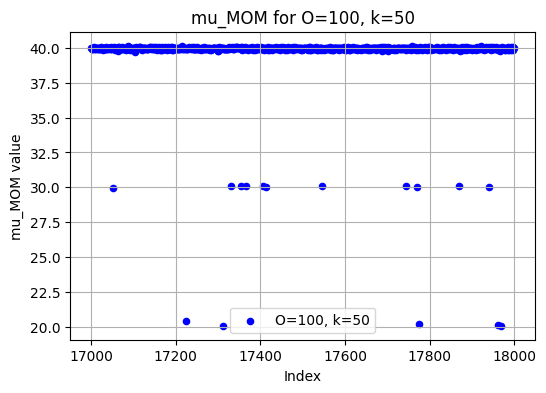

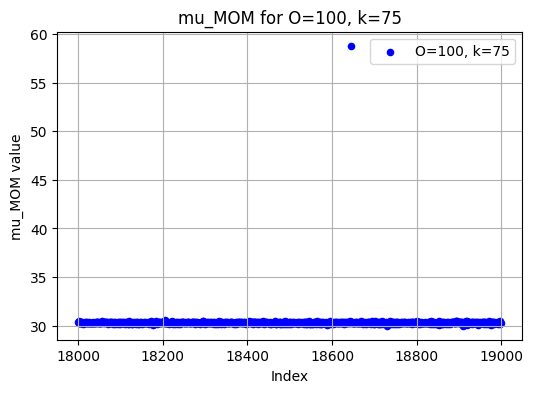

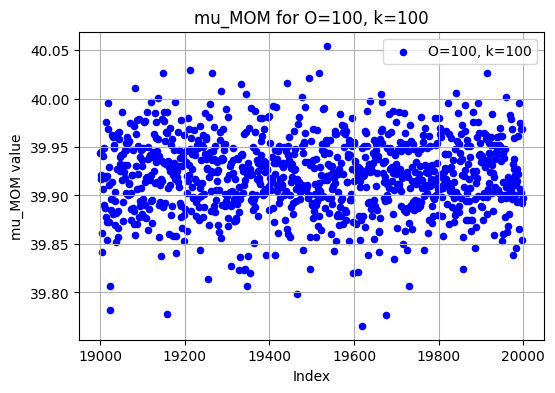

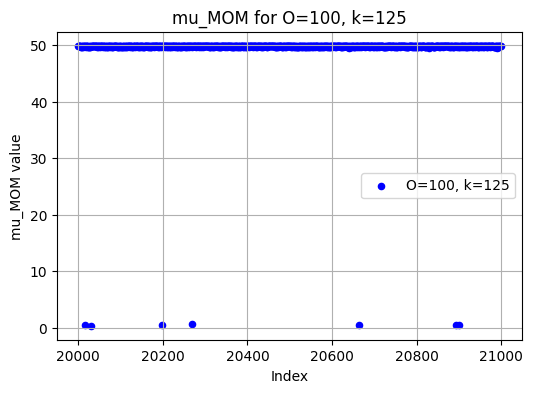

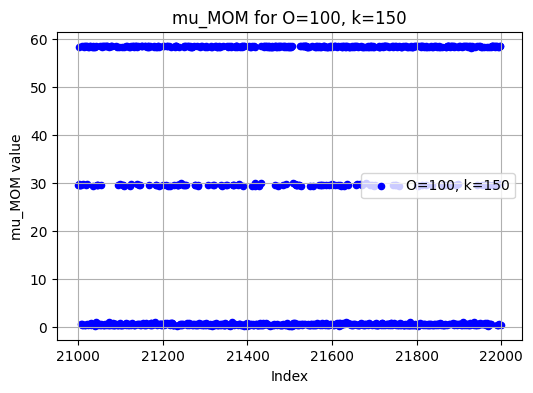

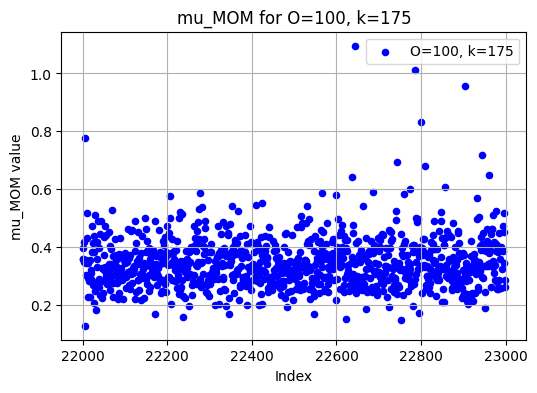

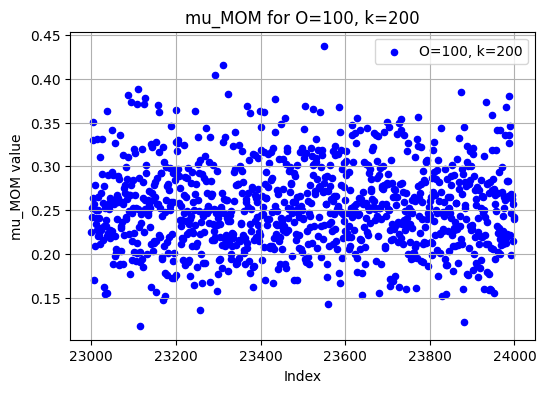

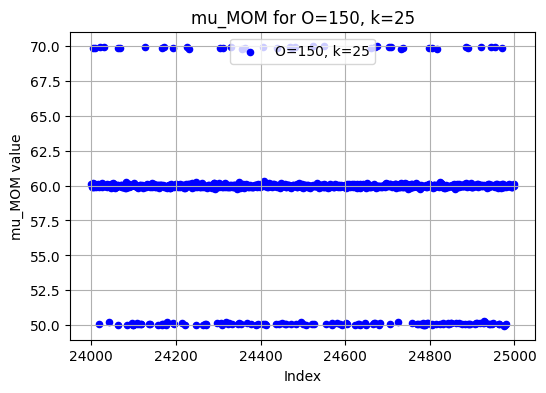

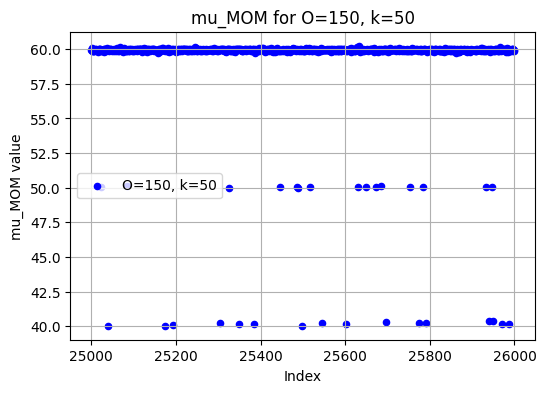

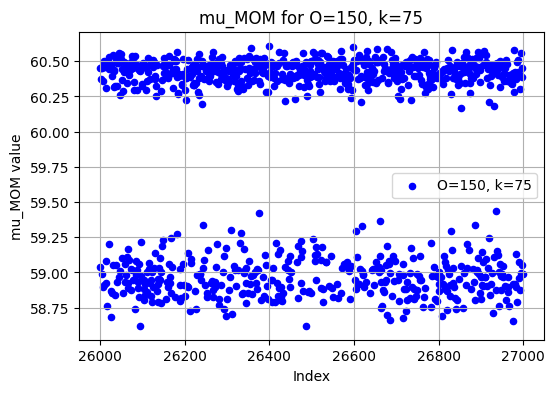

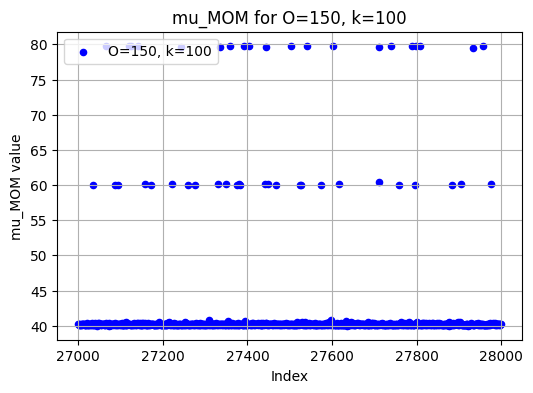

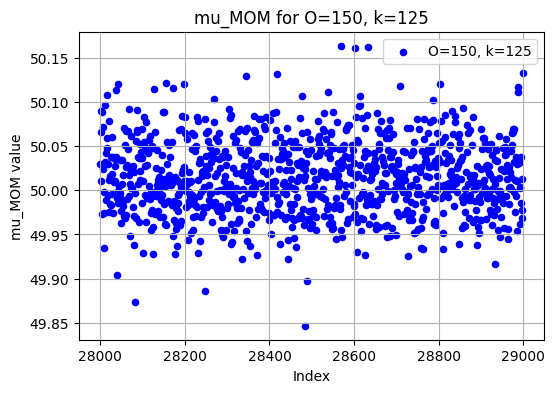

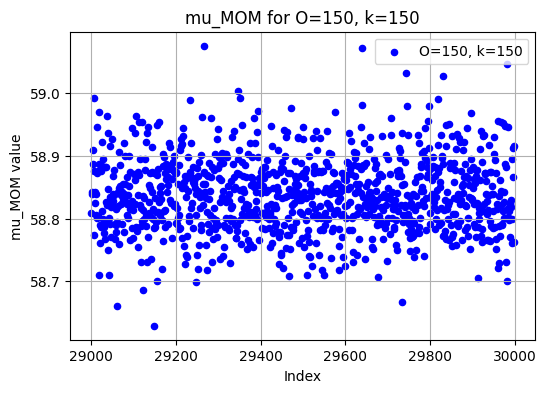

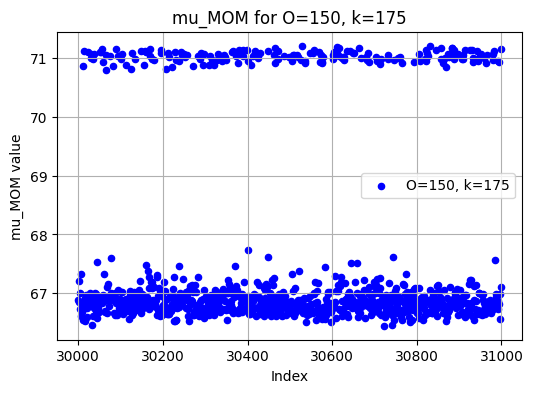

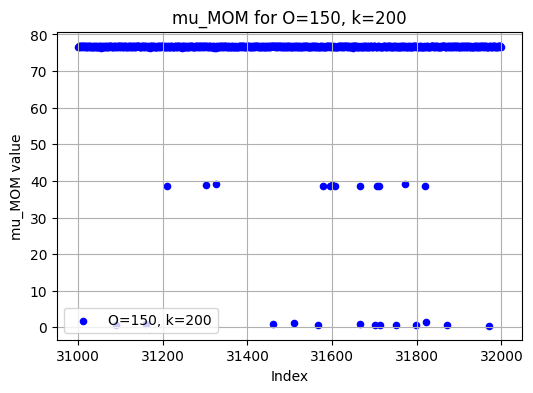

In [137]:
plot_mu_MOM2(mu_MOM_print, O_values, k_values, simulations)

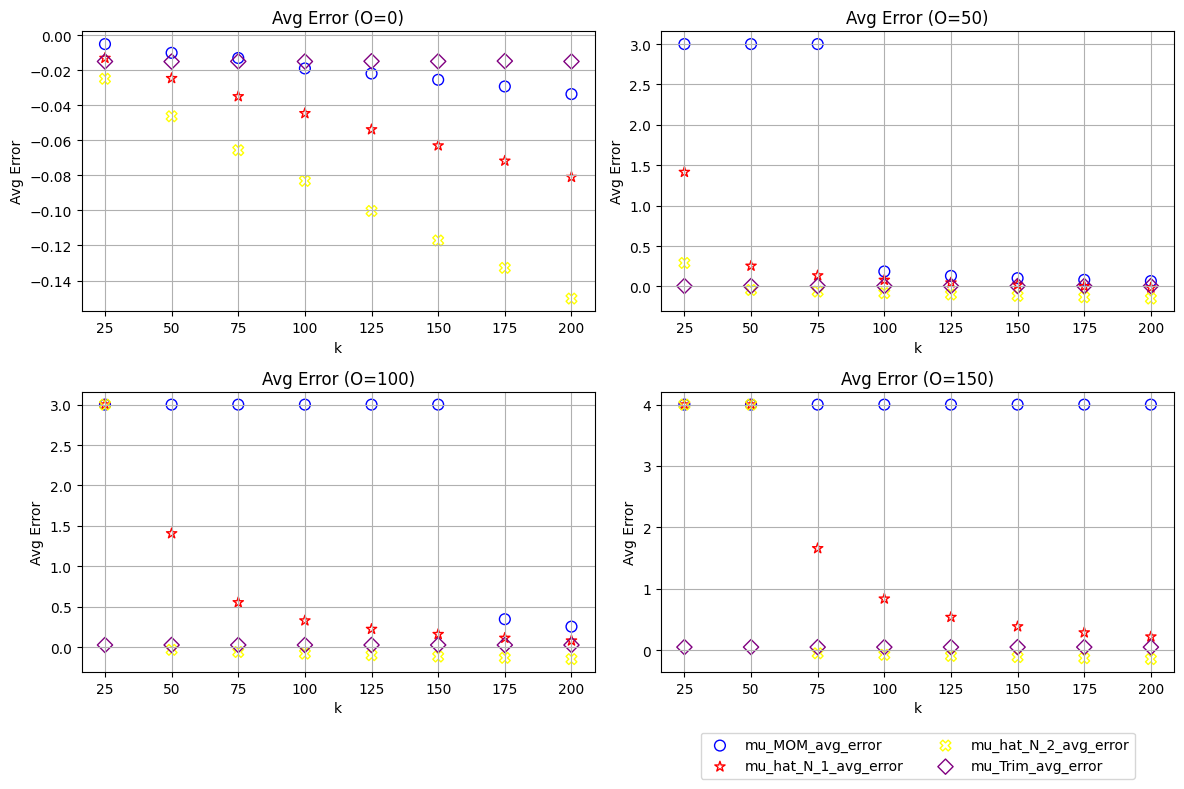

In [136]:
plots(results_df, O_values, "avg_error", estimators, "Avg Error")

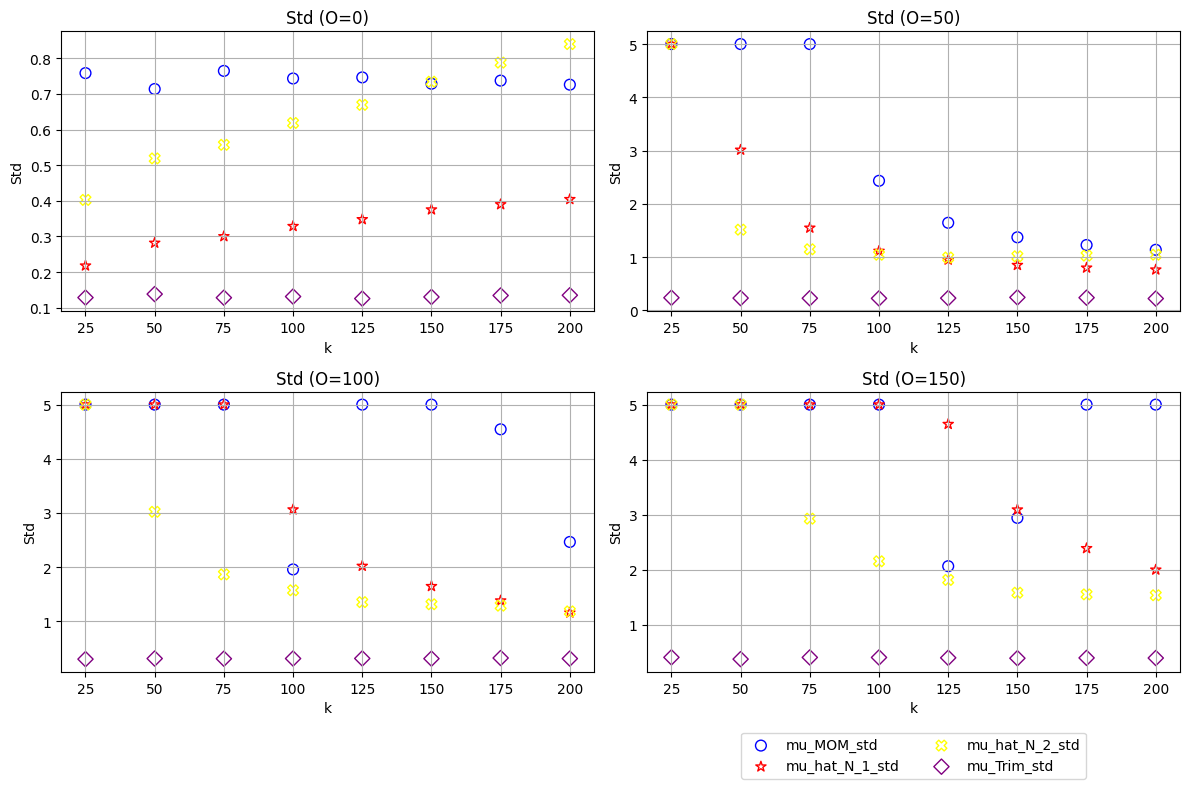

In [135]:
plots(results_df, O_values, "std", estimators, "Std")

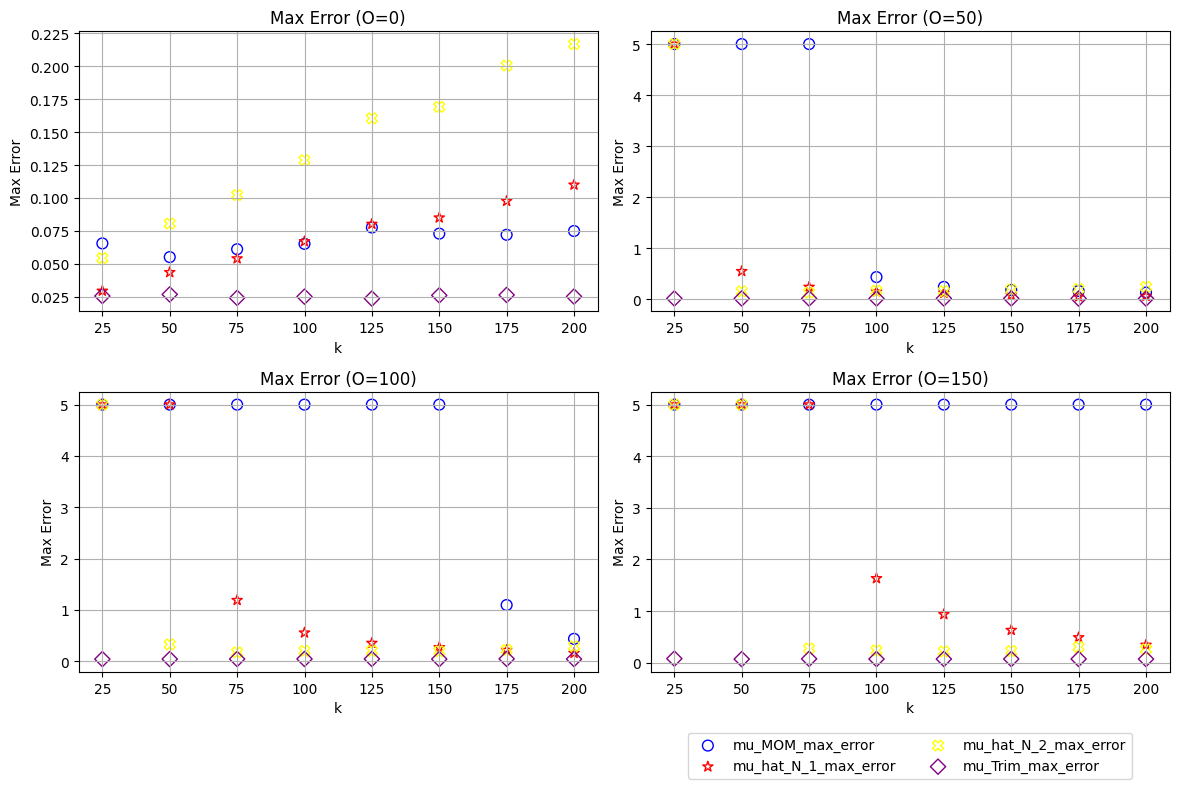

In [134]:
plots(results_df, O_values, "max_error", estimators, "Max Error")